# Some Random Number Generators with MyHDL

I needed a random number generator (RNG) to test the SDRAM on 
my [CAT Board](https://hackaday.io/project/7982-cat-board).
This seemed like a good project to demonstrate the use of [MyHDL](http://www.myhdl.org/)
as a hardware description language.

The main reason I like MyHDL is that it's based on Python.
As such, it can take advantage of the entire Python software ecosystem.
For example, this document uses the popular [Jupyter Notebook](http://jupyter.org/):
not only can you read it, you can also *interact* with it by
changing the parameters and MyHDL code and watching the effects.
In addition, Jupyter uses the [matplotlib](http://matplotlib.org/) Python library
to support *data visualizations* (that's what data scientists call graphs).
And then there's the [numpy]() library that provides a wide assortment of numerical
methods for manipulating data.
In the following paragraphs, I'll show how I used all these to:

1. Build and simulate a RNG with a uniform probability distribution and then convert it
   into a hardware description that can run on an FPGA.
2. Build a RNG with a normal distribution and then detect
   that the distribution is incorrect.

## A Simple LFSR RNG

We'll begin with the most common hardware RNG: the [linear feedback shift register](https://en.wikipedia.org/wiki/Linear_feedback_shift_register) (LFSR).
It consists of a shift-register where the bits at several positions (or *taps*)
are XORed together to create a single bit that is fed into the least-significant
bit of the register on each clock cycle.

![An LFSR](http://davos.science.upm.ro/~apetrescu/OLD/public_html/Curs%20Securitatea%20Informatiilor/Stream%20Ciphers/Linear%20feedback%20shift%20register%20-%20Wikipedia,%20the%20free%20encyclopedia_files/Lfsr.gif)

The taps for an LFSR are referred to as its *polynomial* (due to the origin of
LFSRs in finite-field arithmetic, blah-blah-blah).
If you choose the correct polynomial, an LFSR with an $N$-bit shift register will
cycle through a sequence of $2^N-1$ distinct values.
Luckily, the set of taps for each value of $N$ have been tabulated
so we don't have to figure them out ourselves.
Below are the taps I extracted from a [PDF](http://www.xilinx.com/support/documentation/application_notes/xapp052.pdf)
and placed into a standard Python dictionary keyed with the length of the LFSR.

In [58]:
# Maximum-length LFSR taps from Table 3 of XAPP 052: 
# http://www.xilinx.com/support/documentation/application_notes/xapp052.pdf
lfsr_taps = {
    3: (3, 2),
    4: (4, 3),
    5: (5, 3),
    6: (6, 5),
    7: (7, 6),
    8: (8, 6, 5, 4),
    9: (9, 5),
    10: (10, 7),
    11: (11, 9),
    12: (12, 6, 4, 1),
    13: (13, 4, 3, 1),
    14: (14, 5, 3, 1),
    15: (15, 14),
    16: (16, 15, 13, 4),
    17: (17, 14),
    18: (18, 11),
    19: (19, 6, 2, 1),
    20: (20, 17),
    21: (21, 19),
    22: (22, 21),
    23: (23, 18),
    24: (24, 23, 22, 17),
    25: (25, 22),
    26: (26, 6, 2, 1),
    27: (27, 5, 2, 1),
    28: (28, 25),
    29: (29, 27),
    30: (30, 6, 4, 1),
    31: (31, 28),
    32: (32, 22, 2, 1),
    33: (33, 20),
    34: (34, 27, 2, 1),
    35: (35, 33),
    36: (36, 25),
    37: (37, 5, 4, 3, 2, 1),
    38: (38, 6, 5, 1),
    39: (39, 35),
    40: (40, 38, 21, 19),
    41: (41, 38),
    42: (42, 41, 20, 19),
    43: (43, 42, 38, 37),
    44: (44, 43, 18, 17),
    45: (45, 44, 42, 41),
    46: (46, 45, 26, 25),
    47: (47, 42),
    48: (48, 47, 21, 20),
    49: (49, 40),
    50: (50, 49, 24, 23),
    51: (51, 50, 36, 35),
    52: (52, 49),
    53: (53, 52, 38, 37),
    54: (54, 53, 18, 17),
    55: (55, 31),
    56: (56, 55, 35, 34),
    57: (57, 50),
    58: (58, 39),
    59: (59, 58, 38, 37),
    60: (60, 59),
    61: (61, 60, 46, 45),
    62: (62, 61, 6, 5),
    63: (63, 62),
    64: (64, 63, 61, 60),
    65: (65, 47),
    66: (66, 65, 57, 56),
    67: (67, 66, 58, 57),
    68: (68, 59),
    69: (69, 67, 42, 40),
    70: (70, 69, 55, 54),
    71: (71, 65),
    72: (72, 66, 25, 19),
    73: (73, 48),
    74: (74, 73, 59, 58),
    75: (75, 74, 65, 64),
    76: (76, 75, 41, 40),
    77: (77, 76, 47, 46),
    78: (78, 77, 59, 58),
    79: (79, 70),
    80: (80, 79, 43, 42),
    81: (81, 77),
    82: (82, 79, 47, 44),
    83: (83, 82, 38, 37),
    84: (84, 71),
    85: (85, 84, 58, 57),
    86: (86, 85, 74, 73),
    87: (87, 74),
    88: (88, 87, 17, 16),
    89: (89, 51),
    90: (90, 89, 72, 71),
    91: (91, 90, 8, 7),
    92: (92, 91, 80, 79),
    93: (93, 91),
    94: (94, 73),
    95: (95, 84),
    96: (96, 94, 49, 47),
    97: (97, 91),
    98: (98, 87),
    99: (99, 97, 54, 52),
    100: (100, 63),
    101: (101, 100, 95, 94),
    102: (102, 101, 36, 35),
    103: (103, 94),
    104: (104, 103, 94, 93),
    105: (105, 89),
    106: (106, 91),
    107: (107, 105, 44, 42),
    108: (108, 77),
    109: (109, 108, 103, 102),
    110: (110, 109, 98, 97),
    111: (111, 101),
    112: (112, 110, 69, 67),
    113: (113, 104),
    114: (114, 113, 33, 32),
    115: (115, 114, 101, 100),
    116: (116, 115, 46, 45),
    117: (117, 115, 99, 97),
    118: (118, 85),
    119: (119, 111),
    120: (120, 113, 9, 2),
    121: (121, 103),
    122: (122, 121, 63, 62),
    123: (123, 121),
    124: (124, 87),
    125: (125, 124, 18, 17),
    126: (126, 125, 90, 89),
    127: (127, 126),
    128: (128, 126, 101, 99),
    129: (129, 124),
    130: (130, 127),
    131: (131, 130, 84, 83),
    132: (132, 103),
    133: (133, 132, 82, 81),
    134: (134, 77),
    135: (135, 124),
    136: (136, 135, 11, 10),
    137: (137, 116),
    138: (138, 137, 131, 130),
    139: (139, 136, 134, 131),
    140: (140, 111),
    141: (141, 140, 110, 109),
    142: (142, 121),
    143: (143, 142, 123, 122),
    144: (144, 143, 75, 74),
    145: (145, 93),
    146: (146, 145, 87, 86),
    147: (147, 146, 110, 109),
    148: (148, 121),
    149: (149, 148, 40, 39),
    150: (150, 97),
    151: (151, 148),
    152: (152, 151, 87, 86),
    153: (153, 152),
    154: (154, 152, 27, 25),
    155: (155, 154, 124, 123),
    156: (156, 155, 41, 40),
    157: (157, 156, 131, 130),
    158: (158, 157, 132, 131),
    159: (159, 128),
    160: (160, 159, 142, 141),
    161: (161, 143),
    162: (162, 161, 75, 74),
    163: (163, 162, 104, 103),
    164: (164, 163, 151, 150),
    165: (165, 164, 135, 134),
    166: (166, 165, 128, 127),
    167: (167, 161),
    168: (168, 166, 153, 151),
}


The MyHDL code for the LFSR that uses these taps is shown below.
The name of the LFSR module is `uniform_rand_gen` (we'll see why later).
It accepts four inputs:

* `clk_i`: A clock input. The LFSR outputs a new value every time there is a positive-going (rising) edge on this input.
* `load_i`: A load control input. A starting value (or *seed*) for the RNG is loaded into the shift register upon a rising clock edge when this signal is high.
* `seed_i`: The input for the seed value.
* `rand_o`: The output for the current value in the LFSR shift register.

The bit-width of `rand_o` is used to set the length of the 
shift register (that's the $N$ value I talked about before).

Then a `mask` is created with a `1` in each tap location.
On every rising edge of the clock input, `mask` is used in the 
`rand_shift` sequential block to extract the bits
at the tap points of the shift register.
Then these bits are XOR'ed together.

If the `load_i` input is inactive, the contents of the shift register
are moved over by one bit and the XOR'ed bit is stored in the
newly-vacated least-significant bit.
If `load_i` *is* active, then the shift register is loaded with the
value on the seed input.

In the final combinational logic block, `rand_out`, the current random value in the shift register
is returned though the `rand_o` output.


In [59]:
from myhdl import *  # Import the MyHDL module.


def uniform_rand_gen(clk_i, enbl_i, load_i, seed_i, rand_o):
    '''Uniform random number generator.'''

    width = len(rand_o)  # Width of random number to be generated.

    shfreg = Signal(intbv(1, 0, rand_o.max)) # Holds random number.

    # Create a mask with 1-bits at each tap position in the random number.
    mask = 0
    for t in lfsr_taps[width]:
        mask = mask | (1 << (t - 1))

    # Sequential process to generate random number.
    @always_seq(clk_i.posedge, reset=None)
    def rand_shift():

        # Mask off the feedback bit values and XOR them.
        bits = shfreg & mask
        xor_bit = 0
        for i in range(width):
            xor_bit = xor_bit ^ bits[i]

        if load_i:
            # Load the random number register with the starting seed value.
            shfreg.next = seed_i
        elif enbl_i:
            # Shift the random number by one bit and push in the XOR bit.
            shfreg.next[len(shfreg):1] = shfreg[len(shfreg) - 1:0]
            shfreg.next[0] = xor_bit

    # Combinational process to output the random number.
    @always_comb
    def rand_out():
        rand_o.next = shfreg

    return instances()


## Testing the LFSR RNG

Now that the RNG has been defined, a *testbench* such as the one below
is needed to drive its inputs and collect the random numbers that are output.

First off, I start by declaring a global python list, `rand_seq`, where I can collect the
output of the RNG.
I'll need that later to check the distribution of values.

The actual testbench function starts by declaring the signals needed to drive
the RNG and receive its output.
Then, the RNG module is instantiated.
(Note that the name of the module is passed in as the `rng` parameter.
That will let me use the same testbench with different types of RNGs.)

The actual test sequence is executed in the `tb` block.
The seed is loaded into the RNG on the first clock pulse, and then the
random numbers are collected into the `rand_seq` list for the requested
number of clock pulses.

In [60]:
rand_seq = []  # Store the generated random numbers here.

def rand_gen_tb(rng, width, n_cycles):

    # Define the signals that connect to the RNG.
    clk = Signal(bool(0))
    enbl = Signal(bool(0))
    load = Signal(bool(0))
    rand = Signal(intbv(0)[width:])  # This sets the #bits for the random numbers.
    seed = 42  # 42 is the answer for everything, so use it for the RNG seed.

    # Instantiate the given RNG model and connect it to the defined signals.
    dut = rng(clk, enbl, load, seed, rand)

    @instance
    def tb():
        
        enbl.next = 1  # Enable random number generation.
        load.next = 1  # Load the random number seed on the 1st clock pulse.
        for _ in range(n_cycles):
            
            # Generate a new randon number by pulsing the clock.
            clk.next = 0
            yield delay(1)
            clk.next = 1
            yield delay(1)
            
            rand_seq.append(int(rand.val))  # Store the current output of the RNG.
            load.next = 0  # Turn off seed loading for the remaining clock pulses.

    return instances()


Once the testbench is defined, it's just a matter of instantiating it.
In this case, the `uniform_rand_gen` module is passed into the testbench.
The width of the random numbers is set to 16 bits and the number of
clock cycles is set to the maximum length of the LFSR.

In [61]:
tb = rand_gen_tb(uniform_rand_gen, 16, 2**16-1)  # Instantiate testbench.

Next, a `Simulation` object is created from the testbench.
Then the `run` method of the simulation object is executed.
Once that finishes, the `rand_seq` global list will be filled with
65,535 numbers generated by the RNG.

In [62]:
sim = Simulation(tb)                           # Create simulation from the testbench.
sim.run()                                      # Run the simulation.

<class 'myhdl.StopSimulation'>: No more events


0

In order to see the distribution of the random numbers, I can use the 
matplotlib library to generate a histogram of the values in `rand_seq`.
As you can see, the numbers are *uniformly* distributed across the 
range of values, hence the name `uniform_rand_gen` for the module.
(Of course, an $N$-bit, maximal-length LFSR is going to output every value between 1
and $2^N-1$ exactly once, so naturally the distribution is uniform if
I generate $2^N-1$ numbers.)

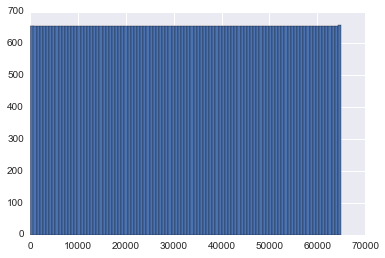

In [63]:
# Setup the notebook for displaying plots of the data within the notebook.
%matplotlib inline
import seaborn as sns            # Use the pretty Seaborn coloring for the plots.
import matplotlib.pyplot as plt  # Load the plotting library.

# Show a histogram of the random numbers that were generated.
bins = list(range(0,65535,656)) # Divide the random number range into 100 bins.
plt.hist(rand_seq, bins)
plt.show()

A uniform distribution is good, but it doesn't tell the whole story.
By taking successive numbers from the random sequence and plotting them as X,Y
pairs, I can get a feel for how much correlation there is between the
samples.
Ideally, I would like to see the X-Y plane evenly covered with points,
indicating that the X and Y values don't affect each other
(i.e., they're uncorrelated).

Unfortunately, as you can see in the graph below, the X and Y values are
heavily correlated and lie on two lines within the X-Y plane.
This makes sense since the next value output by an LFSR is just the current
value multiplied by 2 (i.e., left-shifted) followed by the addition of a 0 or 1,
(the value of the XOR'ed bits), and then truncated to fit within the random
number width.

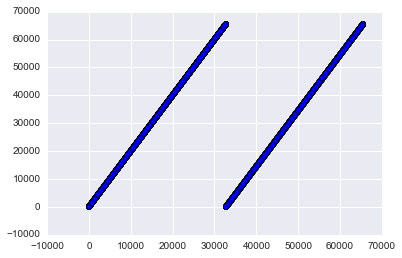

In [64]:
# Plot successive random numbers as (x,y) pairs.
x = rand_seq[:]
y = rand_seq[1:] + rand_seq[-1:]
plt.scatter(x,y)
plt.show()

## Conversion to an FPGA-Based LFSR RNG

Even if the LFSR RNG suffers from correlation of its samples,
it's still a good module for injecting values into a RAM to
detect errors.
But, at this point, it's still just a simulation.
What I really want is something I can load into an FPGA.
MyHDL provides a pathway for that with its *conversion functions*.
For example, to get an implementation of the `uniform_rand_gen`
module in Verilog, I do this:

In [65]:
# Define the signals going in and out of the module.
clk = Signal(bool(0))
enbl = Signal(bool(0))
load = Signal(bool(0))
seed = Signal(intbv(0)[16:]) # The value of the seed doesn't matter here.
rand = Signal(intbv(0)[16:])

# Generate the Verilog implementation of the uniform random number generator.
toVerilog(uniform_rand_gen, clk, enbl, load, seed, rand)

# Read the contents of the Verilog file and print it.
with open('uniform_rand_gen.v') as f:
    print(f.read())

// File: uniform_rand_gen.v
// Generated by MyHDL 1.0dev
// Date: Sat Feb 13 11:57:08 2016


`timescale 1ns/10ps

module uniform_rand_gen (
    clk_i,
    enbl_i,
    load_i,
    seed_i,
    rand_o
);
// Uniform random number generator.

input clk_i;
input enbl_i;
input load_i;
input [15:0] seed_i;
output [15:0] rand_o;
wire [15:0] rand_o;

reg [15:0] shfreg;






assign rand_o = shfreg;


always @(posedge clk_i) begin: UNIFORM_RAND_GEN_RAND_SHIFT
    integer i;
    integer bits;
    integer xor_bit;
    bits = (shfreg & 53256);
    xor_bit = 0;
    for (i=0; i<16; i=i+1) begin
        xor_bit = (xor_bit ^ bits[i]);
    end
    if (load_i) begin
        shfreg <= seed_i;
    end
    else if (enbl_i) begin
        shfreg[16-1:1] <= shfreg[(16 - 1)-1:0];
        shfreg[0] <= xor_bit;
    end
end

endmodule



Looking at the Verilog code, you'll see all the generality of the MyHDL code is
gone (e.g., the table of LFSR taps and the mask calculation) and the Verilog is
specifically tuned for generating 16-bit random numbers with a fixed XOR mask
(53256 in this case).

Getting a VHDL version is similarly easy:

In [66]:
toVHDL(uniform_rand_gen, clk, enbl, load, seed, rand)

with open('uniform_rand_gen.vhd') as f:
    print(f.read())

-- File: uniform_rand_gen.vhd
-- Generated by MyHDL 1.0dev
-- Date: Sat Feb 13 11:57:08 2016


library IEEE;
use IEEE.std_logic_1164.all;
use IEEE.numeric_std.all;
use std.textio.all;

use work.pck_myhdl_10.all;

entity uniform_rand_gen is
    port (
        clk_i: in std_logic;
        enbl_i: in std_logic;
        load_i: in std_logic;
        seed_i: in unsigned(15 downto 0);
        rand_o: out unsigned(15 downto 0)
    );
end entity uniform_rand_gen;
-- Uniform random number generator.

architecture MyHDL of uniform_rand_gen is



signal shfreg: unsigned(15 downto 0);

begin






rand_o <= shfreg;


UNIFORM_RAND_GEN_RAND_SHIFT: process (clk_i) is
    variable bits: integer;
    variable xor_bit: integer;
begin
    if rising_edge(clk_i) then
        bits := to_integer((shfreg and to_unsigned(53256, 16)));
        xor_bit := 0;
        for i in 0 to 16-1 loop
            xor_bit := to_integer((stdl(xor_bit) xor bits(i)));
        end loop;
        if bool(load_i) then
            s

## Building a Normally-Distributed RNG

Uniformly-distributed random numbers are nice, but sometimes you need something more.
Like normally-distributed (or *Gaussian*) random numbers!

It turns out you can [create a normal distribution by adding several uncorrelated,
uniformly-distributed random numbers](http://www.johndcook.com/blog/2009/02/12/sums-of-uniform-random-values/).
(Usually 12, but 16 is easier hardware-wise), 
So I can use the uniform RNG module I just built, pump its output into a 16-word FIFO,
sum the values in the FIFO, divide it by 16, and output the sum as a normally-distributed
random number.
The MyHDL implementation of that is as follows:

In [67]:
import math  # Need this to compute scaling shift. 

sum_length = 16
base_rng = uniform_rand_gen

def normal_rand_gen(clk_i, enbl_i, load_i, seed_i, rand_o):
    '''Normal (Gaussian) random number generator.'''

    # Instantiate a uniform RNG.
    uni_rand = Signal(intbv(0, 0, rand_o.max))
    uni_rng = base_rng(clk_i, enbl_i, load_i, seed_i, uni_rand)

    # Create a FIFO for storing samples of the uniform random numbers.
    uni_rand_samples = [Signal(intbv(0, 0, rand_o.max)) for _ in range(sum_length)]
    
    # Create a signal with more bits for storing the sum of N random numbers.
    rand_sum = Signal(intbv(0, 0, sum_length*rand_o.max))
    
    # Update the sum of random numbers with a new value on every clock cycle.
    @always_seq(clk_i.posedge, reset=None)
    def uni_sum_to_gauss():
        
        # Create the sum by adding the newest random number and subtracting the oldest.
        rand_sum.next = rand_sum - uni_rand_samples[sum_length-1] + uni_rand
        
        # Then enter the newest into the FIFO while discarding the oldest.
        for i in range(sum_length-1):
            uni_rand_samples[i+1].next = uni_rand_samples[i]
        uni_rand_samples[0].next = uni_rand

    # The sum has to be scaled to be in the same range as the original random numbers.
    scale_shift = int(round(math.log(sum_length,2)))
    
    # Output the scaled sum. This will be a normally-distributed random number.
    @always_comb
    def scale_and_output_sum():
        rand_o.next = rand_sum >> scale_shift

    return instances()


## Testing the Normally-Distributed RNG

The only potential problem with my method for generating a normal distribution
is that successive random numbers spit out by the `uniform_rand_gen` module
aren't really uncorrelated.
But how much of an effect will that have?
Running the simulation testbench with the `normal_rand_gen` module
and checking the distribution of the outputs will
give me some idea.

<class 'myhdl.StopSimulation'>: No more events


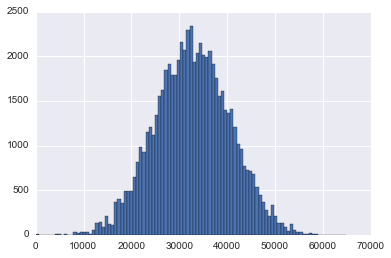

In [68]:
rand_seq = []  # Remove the previous set of uniform random numbers.

# Run the testbench, but use the normal_rand_gen module this time.
tb = rand_gen_tb(normal_rand_gen, 16, 2**16)
sim = Simulation(tb)
sim.run()

# Plot the distribution.
plt.hist(rand_seq, bins)
plt.show()

Well, it *looks* like a normal distribution, but is it?
In order to check it, I can recreate the normal distribution by summing 
samples from Python's uniform RNG.
And then I can lay a curve of a normal distribution over both of those
and see if either of them match.

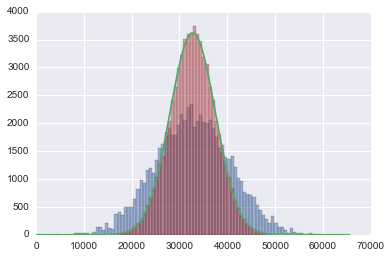

In [69]:
import matplotlib.mlab as mlab
import numpy as np
import random

rnd_rng = 2 ** 16 # The range of the random numbers.

# Recreate the method for generating a normal distribution,
# but use the Python RNG instead of an LFSR.
sum_length = 16  # Add this many uniform random numbers.
ck_rand_sum = 0
ck_rand_seq = []
ck_fifo = [0] * sum_length
for _ in range(rnd_rng):
    ck_r = round(random.uniform(1,rnd_rng)) # Get a random number.
    ck_rand_sum += ck_r - ck_fifo[0] # Add it to the sum and subtract the oldest sample.
    ck_fifo = ck_fifo[1:] + [ck_r] # Discard oldest sample and save newest.
    ck_rand_seq.append(ck_rand_sum/sum_length) # Add new random number to the sequence.

# Create the parameters for a normal distribution scaled
# to account for the random number being in the range [0,rnd_rng].
nrm_mean = rnd_rng / 2
nrm_variance = rnd_rng**2 / 12. * sum_length
nrm_sigma = math.sqrt(nrm_variance) / sum_length
nrm_x = np.linspace(1, rnd_rng, len(bins))
nrm_area = rnd_rng * (rnd_rng/len(bins))  # Scale area of normal to match histogram area.

# Plot the original distribution and the two calculated distributions.
plt.hist(rand_seq, bins, alpha=0.5)
plt.plot(nrm_x,nrm_area*mlab.normpdf(nrm_x, nrm_mean, nrm_sigma))
plt.hist(ck_rand_seq, bins, alpha=0.5)
plt.show()

The probability distribution generated by summing samples from the Python uniform RNG
(in red) and the curve of a normal distribution (in green) match pretty well.
But the distribution generated by summing samples from the LFSR-generated RNG
(in blue) is more spread out (i.e., it has a higher variance).
So the best I can say about it is it's an "abnormal" distribution.

## First Attempt at Fixing the "Abnormally"-Distributed RNG: PIOOMA

In an attempt to correct the correlated output problem of the LFSR, I invented the
PIOOMA ("Pulled It Out Of My Ass") RNG.
It consists of three LFSR RNGs: two which run independently and a third which selects
one of the two outputs based on its least-significant bit.

In [70]:
def piooma_rand_gen(clk_i, enbl_i, load_i, seed_i, rand_o):
    '''Normal (Gaussian) random number generator.'''

    # Instantiate three uniform RNG.
    uni_rand1 = Signal(intbv(0, 0, rand_o.max))
    uni_rng1 = uniform_rand_gen(clk_i, enbl_i, load_i, seed_i, uni_rand1)
    uni_rand2 = Signal(intbv(0, 0, rand_o.max))
    uni_rng2 = uniform_rand_gen(clk_i, enbl_i, load_i, 41, uni_rand2)
    uni_rand3 = Signal(intbv(0, 0, rand_o.max))
    uni_rng3 = uniform_rand_gen(clk_i, enbl_i, load_i, 40, uni_rand3)
    
    @always_comb
    def select_rand_1_or_2():
        if uni_rand3[0]:
            rand_o.next = uni_rand1
        else:
            rand_o.next = uni_rand2

    return instances()

Now I can re-run the testbench with PIOOMA and check the distribution and sample correlations.
You can see the distribution is still uniform.
The X-Y scatter plot also covers more area, so successive random samples may
be less correlated.

<class 'myhdl.StopSimulation'>: No more events


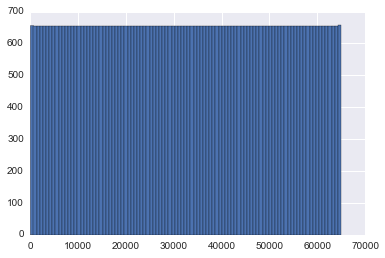

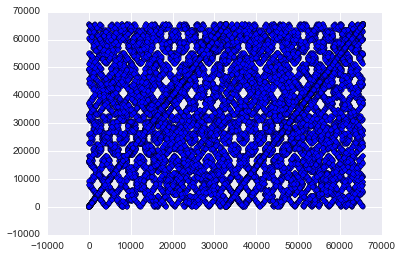

In [71]:
orig_norm_rand_seq = rand_seq[:]  # Save the original random sequence for comparison.
rand_seq = []  # Remove the previous set of random numbers.

# Run the testbench using the PIOOMA RNG.
tb = rand_gen_tb(piooma_rand_gen, 16, 2**16)
sim = Simulation(tb)
sim.run()

# Plot the distribution.
bins = list(range(0,65535,656))
plt.hist(rand_seq, bins)
plt.show()

# Plot the correlation.
x = rand_seq[:]
y = rand_seq[1:] + rand_seq[-1:]
plt.scatter(x,y)
plt.show()

Now I can re-run the `normal_rand_gen`, but using the PIOOMA 
instead of the simple LFSR to generate random numbers in the summation.

<class 'myhdl.StopSimulation'>: No more events


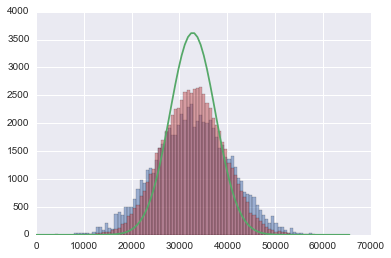

In [72]:
rand_seq = []  # Remove the previous set of uniform random numbers.

# Run the testbench, but use the PIOOMA RNG for generating the normal distribution.
base_rng = piooma_rand_gen
tb = rand_gen_tb(normal_rand_gen, 16, 2**16)
sim = Simulation(tb)
sim.run()

# Plot the distributions.
plt.hist(orig_norm_rand_seq, bins, alpha=0.5)
plt.plot(nrm_x,nrm_area*mlab.normpdf(nrm_x, nrm_mean, nrm_sigma))
plt.hist(rand_seq, bins, alpha=0.5)
plt.show()

The distribution using PIOOMA is a little better than the previous one:
it's slightly narrower and taller and more closely matches the normal curve.
But it's not enough of an improvement considering it triples the number
of LFSRs used.

## Second Attempt at Fixing the "Abnormally"-Distributed RNG: Xorshift

A better solution is the [Xorshift RNG](https://en.wikipedia.org/wiki/Xorshift).
It uses shifts and XORs like the LFSR while generating a better distribution,
but it requires careful selection of the seed values in the generator.

[One implementation of a 32-bit Xorshift](http://www.donnelly-house.net/programming/cdp1802/8bitPRNGtest.html)
is as follows:

```c
public long randomLong() {
  x ^= (x << 21);
  x ^= (x >>> 35);
  x ^= (x << 4);
  return x;
}

Original 32-bit C function: ( http://en.wikipedia.org/wiki/Xorshift )

   uint32_t xor128(void) {
     static uint32_t x = 123456789;
     static uint32_t y = 362436069;
     static uint32_t z = 521288629;
     static uint32_t w = 88675123;
     uint32_t t;

     t = x ^ (x << 11);
     x = y;
     y = z;
     z = w;
     return w = w ^ (w >> 19) ^ (t ^ (t >> 8));
   }
```

Below is a translation of this C code into a MyHDL module:

In [73]:
def xorshift_rand_gen(clk_i, enbl_i, load_i, seed_i, rand_o):
    '''Uniform random number generator.'''

    x, y, z, w, t = [Signal(intbv(0,0,2**32)) for _ in range(5)]
    
    # Sequential process to generate random number.
    @always_seq(clk_i.posedge, reset=None)
    def rand_shift():

        if load_i:
            # Load the random number register with the starting seed value.
            # (The seed_i input is ignored.)
            x.next = 123456789
            y.next = 362436069
            z.next = 521288629
            w.next = 88675123
        elif enbl_i:
            t.next = x ^ (x << 11)[32:0]
            x.next = y
            y.next = z
            z.next = w
            w.next = w ^ (w>>19) ^ (t ^ (t>>8))

    # Combinational process to output the random number.
    # The maximum width of the output is 32 bits.
    @always_comb
    def rand_out():
        rand_o.next = w[len(rand_o):0]

    return instances()

Running the testbench on the `xorshift_rand_gen` module produces
the nearly uniform distribution shown below.
Also, the scatter plot of successive samples *covers the entire X-Y plane*:
the correlation artifacts are completely absent.

<class 'myhdl.StopSimulation'>: No more events


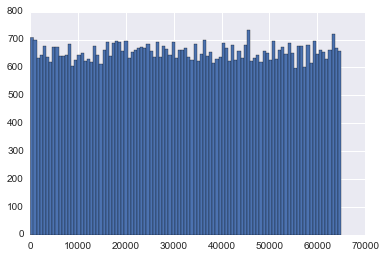

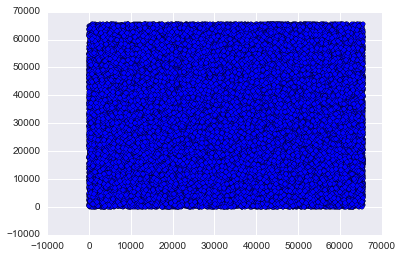

In [74]:
rand_seq = []  # Remove the previous set of random numbers.

# Run the testbench using the xorshift_rand_gen module.
tb = rand_gen_tb(xorshift_rand_gen, 16, 2**16)
sim = Simulation(tb)
sim.run()

# Plot the distribution.
plt.hist(rand_seq, bins)
plt.show()

# Plot the correlation.
x = rand_seq[:]
y = rand_seq[1:] + rand_seq[-1:]
plt.scatter(x,y)
plt.show()

Now I can re-run the `normal_rand_gen` module using the Xorshift RNG
to see if the resulting distribution more closely matches the normal curve.

<class 'myhdl.StopSimulation'>: No more events


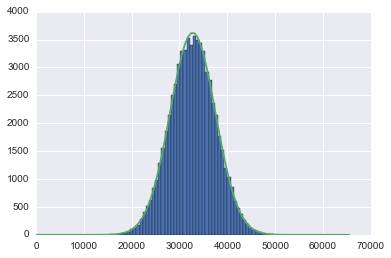

In [75]:
rand_seq = []  # Remove the previous set of uniform random numbers.

# Run the testbench, but use the Xorshift RNG for generating the normal distribution.
base_rng = xorshift_rand_gen
tb = rand_gen_tb(normal_rand_gen, 16, 2**16)
sim = Simulation(tb)
sim.run()

# Plot the distribution.
plt.hist(rand_seq, bins)
plt.plot(nrm_x,nrm_area*mlab.normpdf(nrm_x, nrm_mean, nrm_sigma))
plt.show()

That's pretty good!
The Xorshift RNG definitely generates a distribution very close to being normal.

## Conversion to an FPGA-Based Normally-Distributed RNG

Just as with the LFSR RNG, getting a Verilog or VHDL description of the 
Normally-Distributed RNG is very easy.

In [76]:
sum_length = 16
base_rng = xorshift_rand_gen

# Define the signals going in and out of the module.
clk = Signal(bool(0))
enbl = Signal(bool(0))
load = Signal(bool(0))
seed = Signal(intbv(0)[16:0]) # The value of the seed doesn't matter here.
rand = Signal(intbv(0)[16:])

# Generate the Verilog implementation of the normally-distributed RNG.
toVerilog(normal_rand_gen, clk, enbl, load, seed, rand)

# Read the contents of the Verilog file and print it.
with open('normal_rand_gen.v') as f:
    print(f.read())

print('\n\n', '*' * 60, '\n\n')

# Generate the VHDL implementation of the normally-distributed RNG.
toVHDL(normal_rand_gen, clk, enbl, load, seed, rand)

# Read the contents of the VHDL file and print it.
with open('normal_rand_gen.vhd') as f:
    print(f.read())

** ToVerilogWarning: Port is not used: seed_i
** ToVHDLWarning: Port is not used: seed_i

// File: normal_rand_gen.v
// Generated by MyHDL 1.0dev
// Date: Sat Feb 13 11:58:21 2016


`timescale 1ns/10ps

module normal_rand_gen (
    clk_i,
    enbl_i,
    load_i,
    seed_i,
    rand_o
);
// Normal (Gaussian) random number generator.

input clk_i;
input enbl_i;
input load_i;
input [15:0] seed_i;
output [15:0] rand_o;
wire [15:0] rand_o;

reg [19:0] rand_sum;
wire [15:0] uni_rand;
reg [31:0] uni_rng_w;
reg [31:0] uni_rng_x;
reg [31:0] uni_rng_t;
reg [31:0] uni_rng_y;
reg [31:0] uni_rng_z;

reg [15:0] uni_rand_samples [0:16-1];





assign rand_o = (rand_sum >>> 4);


always @(posedge clk_i) begin: NORMAL_RAND_GEN_UNI_SUM_TO_GAUSS
    integer i;
    rand_sum <= (($signed({1'b0, rand_sum}) - $signed({1'b0, uni_rand_samples[(16 - 1)]})) + uni_rand);
    for (i=0; i<(16 - 1); i=i+1) begin
        uni_rand_samples[(i + 1)] <= uni_rand_samples[i];
    end
    uni_rand_samples[0] <= uni_rand;
end



assign uni_rand = uni_rng_w[16-1:0];


always @(posedge clk_i) begin: NORMAL_RAND_GE

## Conclusion